# Классификация текстов

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
12965,19519,64471,Kenya,22-03-2020,With the the Covid-19 epidemic! Heri Online wi...,Extremely Positive
3545,8103,53055,NaN,18-03-2020,Grocery store workers are skilled workers. Rig...,Positive
15040,22086,67038,"Toronto, Ontario",23-03-2020,"To protect against inflated prices, Facebook i...",Negative
18192,25933,70885,rural Ontario,25-03-2020,Gas plummets to around 65 cents per litre Pric...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



Целевая переменная находится в колонке `Sentiment`.  Преобразуем ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [ ]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ['Positive', 'Extremely Positive'] else 0)


In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
1,18046
0,15398


 Классы досточно сбалансированы, класс "1": 18046/33444 * 100 = 54%, класс "0": 46%

In [ ]:
df.isnull().sum()

,0
UserName,0
ScreenName,0
Location,7049
TweetAt,0
OriginalTweet,0
Sentiment,0


In [ ]:
df.fillna('Unknown', inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Токенизация

Построим словарь на основе обучающей выборки и посчитаем количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [ ]:
from collections import Counter

tokens = Counter()

for text in train['OriginalTweet']:
    tokens.update(text.lower().split())

In [ ]:
len(tokens)

79755

In [ ]:
tokens.most_common(10)

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

Часто в топе встречаются стоп-слова(the, to, and и тд) — служебные слова, не несущие содержательной нагрузки, а также часто встречается популярный хештег #coronavirus, тк данные за 2020 год

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

tokens = Counter({token: count for token, count in tokens.items() if token not in stop_words})

tokens.most_common(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

 Теперь в топе только полезные токены, которые показывают, что многих людей беспокоит тема ковида, а также тема магазинов в связи с локдауном

In [ ]:
tokens.most_common()[-20:]

[('skellig', 1),
 ('coast!', 1),
 ('closer!)', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã\x82â\x92', 1),
 ('renewing', 1),
 ('wage!', 1),
 ('flew', 1),
 ('nothing...', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

Многие из этих токенов не разделены на слова, тк написаны без пробелов, также тут присутствуют уникальные упоминания или имена пользователей, ссылки всегда разные, поэтому тоже встречаются по одному разу\
Некоторые из этих токенов стоит удалить или обработать(ссылки, ники, ошибки кодировки и хештеги без пробелов)



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk.

In [ ]:
from nltk.tokenize import TweetTokenizer

tt = TweetTokenizer()
counter = Counter()

for text in train['OriginalTweet']:
    tokens = tt.tokenize(text.lower())
    counter.update(tokens)

counter.most_common(10)

[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

TweetTokenizer также учитывает и отделяет знаки припинания, смайлики и символы, поэтому в топе появились знаки пунктуации

In [ ]:
from string import punctuation

new_tokens = Counter({token: count for token, count in counter.items()
    if token not in stop_words and token not in punctuation})

new_tokens.most_common(10)

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

Появились непонятные слова, скорее всего ошибки, буква не из латинского алфавита и цифры

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их.


In [ ]:
new_tokens = Counter({token: count for token, count in new_tokens.items()
    if not (len(token) == 1 and ord(token) >= 128)})

new_tokens.most_common(10)

[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

In [ ]:
new_tokens.most_common()[-20:]

[('https://t.co/lw1r0rm7xs', 1),
 ('https://t.co/5cbliqzx7l', 1),
 ('now.when', 1),
 ('milion', 1),
 ('skellig', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã', 1),
 ('renewing', 1),
 ('flew', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2y3rsld9', 1)]

Непопулярные токены почти не изменились, остались ссылки, в популярные добавился токен "covid" и "#covid19", в целом разница не очень сильна заметна

In [ ]:
Counter({token: count for token, count in new_tokens.items() if token.startswith('#')}).most_common(10)

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

Все популявные хештеги содержат короновирус и слова относящиеся к нему

In [ ]:
Counter({token: count for token, count in new_tokens.items() if token.startswith('https://t.co')}).most_common(10)

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3)]

Ссылки встречаются нечасто, также не несут никакой эмоциональной окраски, только если перейти по ссылке можно получить хоть какую то информацию

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [ ]:
def custom_tokenizer(text):
  tt = TweetTokenizer()
  stop_words = set(stopwords.words('english'))
  tokens = tt.tokenize(text.lower())

  tokens = [
      token for token in tokens
      if token not in stop_words
      and token not in punctuation
      and not (len(token) == 1 and ord(token) >= 128)
      and not token.startswith('https://t.co')
  ]
  return tokens


In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Векторизация текстов

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45290


 Размер сильно сократился с 79755 до 45290, потому что в нем присутствовали: пунктуация, ссылки, слова с ошибками кодировки, стоп-слова.
После очистки словаря кастомной токенизацией его размер сократился, что говорит об улучшении качества признаков.



Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Применим обученный CountVectorizer для векторизации данного текста, и попытаемся определить самый важный токен и самый неважный токен.

In [ ]:
text = train.iloc[ind]['OriginalTweet']
vector = cv.transform([text])
tokens = vector.toarray()[0]

vocab = {v: k for k, v in cv.vocabulary_.items()}
token_freqs = [(vocab[i], tokens[i]) for i in tokens.nonzero()[0]]

max(token_freqs, key=lambda x: x[1]), min(token_freqs, key=lambda x: x[1])

(('#coronavirusoutbreak', np.int64(1)), ('#coronavirusoutbreak', np.int64(1)))

Не очень хорошо определены, в твите каждое слово встречается только 1 раз, поэтому получился такой ответ, также этот способ не отображает эмоциональную окраску, тк самые частые слова бывают нейтральные.

Теперь применем TfidfVectorizer.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf.fit(train['OriginalTweet'])

vector = tfidf.transform([text])
tokens = vector.toarray()[0]
token_scores = [(vocab[i], tokens[i]) for i in tokens.nonzero()[0]]

max(token_scores, key=lambda x: x[1]), min(token_scores, key=lambda x: x[1])

(('brainless', np.float64(0.3867641170466375)),
 ('food', np.float64(0.11328893069250721)))

 Хорошо определилось негативно окрашенное слово `brainless`, которое отражает главный смысл твита







Найдем какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен.



In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x.lower()) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
14710,21683,66635,"iPhone: 30.738749,-89.852348",23-03-2020,Amazing how some of the lowest paid people in ...,1
27471,37481,82433,"New York, NY",08-04-2020,Amazing and admirable work being done by all g...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [ ]:
example = train[train['OriginalTweet'].apply(lambda x: 'amazing' in x.lower()) & (train['Sentiment'] == 1)].iloc[3]

text = example['OriginalTweet']

vector = tfidf.transform([text])
tokens = vector.toarray()[0]
token_scores = [(vocab[i], tokens[i]) for i in tokens.nonzero()[0]]

mx = max(token_scores, key=lambda x: x[1])
print(text)
print(mx)

Let s just take a minute to say THANK YOU also to the amazing postal workers So many real people behind a click of online shopping and getting cards delivered Thank   you   19
('thank', np.float64(0.3691299729428482))


 В этом твите TfidfVectorizer выделил слово `thank`, которое отражает позитивный окрас этого предложения

## Обучение моделей

In [ ]:
cv = CountVectorizer(tokenizer=custom_tokenizer)
X_train, X_test = train['OriginalTweet'], test['OriginalTweet']
y_train, y_test = train['Sentiment'], test['Sentiment']
X_cv = cv.fit_transform(X_train)
X_cv_test = cv.transform(X_test)


tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
X_tfidf = tfidf.fit_transform(X_train)
X_tfidf_test = tfidf.transform(X_test)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучим логистическую регрессию на векторах из обоих векторайзеров.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_cv = LogisticRegression(max_iter=1000)
model_cv.fit(X_cv, y_train)

model_tfidf = LogisticRegression(max_iter=1000)
model_tfidf.fit(X_tfidf, y_train)

print("accuracy CV train and test:", accuracy_score(y_train, model_cv.predict(X_cv)), accuracy_score(y_test, model_cv.predict(X_cv_test)))
print("accuracy TFIDF train and test:", accuracy_score(y_train, model_tfidf.predict(X_tfidf)), accuracy_score(y_test, model_tfidf.predict(X_tfidf_test)))

accuracy CV train and test: 0.9846646732165741 0.8670520231213873
accuracy TFIDF train and test: 0.9224263135412217 0.85280047837353


Очень высокая точность на train у CV может говорить о возможном переобучении, у TFIDF почти такая же точность на test, но ниже точность на train, что указывает на лучшую обобщающую способность (меньше переобучения).



## Стемминг

Для уменьшения словаря можно использовать стемминг.



In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

def custom_stem_tokenizer(text):
  tt = TweetTokenizer()
  stop_words = set(stopwords.words('english'))
  tokens = tt.tokenize(text.lower())
  tokens = [
      stemmer.stem(token) for token in tokens
      if token not in stop_words
      and token not in punctuation
      and not (len(token) == 1 and ord(token) >= 128)
      and not token.startswith('https://t.co')]
  return tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
X_cv = cv.fit_transform(X_train)
print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36634


In [ ]:
tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
X_tfidf= tfidf.fit_transform(X_train)
len(tfidf.vocabulary_)

36634

Размер словаря уменьшился после применения стемминга, так как различные формы слов были приведены к их основе.

In [ ]:
model_cv_stem = LogisticRegression(max_iter=1000)
model_cv_stem.fit(X_cv, y_train)

model_tfidf_stem = LogisticRegression(max_iter=1000)
model_tfidf_stem.fit(X_tfidf, y_train)


X_cv_stem_test = cv.transform(X_test)
X_tfidf_stem_test = tfidf.transform(X_test)

print("Accuracy CV Stem train and test:",  accuracy_score(y_train, model_cv_stem.predict(X_cv)), accuracy_score(y_test, model_cv_stem.predict(X_cv_stem_test)))
print("Accuracy TFIDF Stem train and test:", accuracy_score(y_train, model_tfidf_stem.predict(X_tfidf)), accuracy_score(y_test, model_tfidf_stem.predict(X_tfidf_stem_test)))

Accuracy CV Stem train and test: 0.9720205040580948 0.8674506677297189
Accuracy TFIDF Stem train and test: 0.9165741136266553 0.8559896352401833


Стемминг дал небольшой прирост качества на тестовых данных, особенно для Tfidf, также train accuracy снизилась, а это хороший признак уменьшения переобучения.


## Работа с частотами

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберем min_df.

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11)
X_train_cv = cv_df.fit_transform(X_train)
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3687


In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_cv, y_train)
print("Accuracy train and test:", accuracy_score(y_train, model.predict(X_train_cv)), accuracy_score(y_test, model.predict(cv_df.transform(X_test))))

Accuracy train and test: 0.9290046988466467 0.8680486346422165


 Размер словаря уменьшился, а accuracy на train уменьшилась, а на test увеличилать, что очень хорошо

В предыдущих заданиях признаки не скалировались. Отскалируем данные.

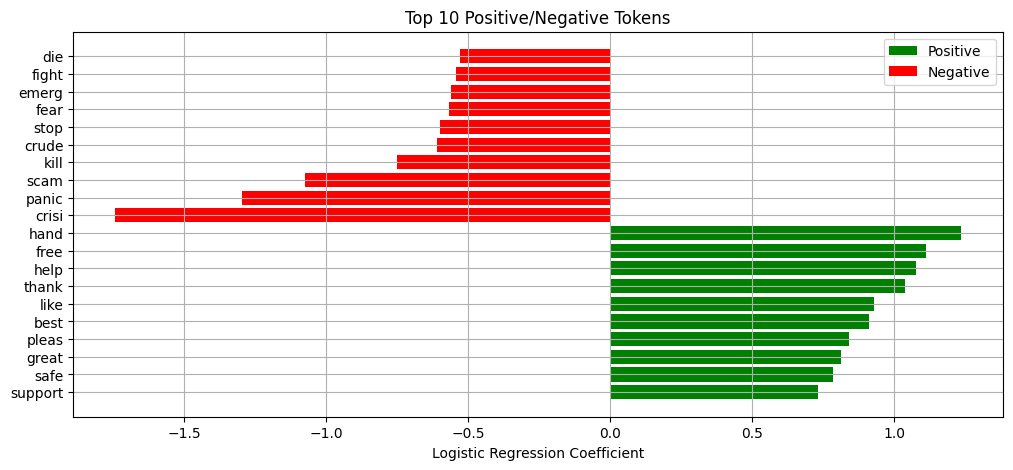

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X_test_cv = cv_df.transform(X_test)

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_cv)
X_test_scaled = scaler.transform(X_test_cv)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)


feature_names = np.array(cv_df.get_feature_names_out())
coefs = model.coef_[0]


top_positive = np.argsort(coefs)[-10:]
top_negative = np.argsort(coefs)[:10]

plt.figure(figsize=(12, 5))

plt.barh(feature_names[top_positive], coefs[top_positive], color='green', label='Positive')
plt.barh(feature_names[top_negative], coefs[top_negative], color='red', label='Negative')
plt.title("Top 10 Positive/Negative Tokens")
plt.xlabel("Logistic Regression Coefficient")
plt.legend()
plt.grid(True);

У всех токенов правильно определен окрас, также можно наглядно увидеть их популярность

## Другие признаки

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

In [ ]:
print("Уникальных UserName и всего UserName:", train['UserName'].nunique(), len(train['UserName']))
print("Уникальных ScreenName и всего ScreenName:", train['ScreenName'].nunique(), len(train['ScreenName']))

Уникальных UserName и всего UserName: 23410 23410
Уникальных ScreenName и всего ScreenName: 23410 23410


 Все имена и ники уникальны, поэтому нет смысла с ними работать

Нарисуем  гистограмму признака TweetAt с разделением по цвету на основе целевой переменной.

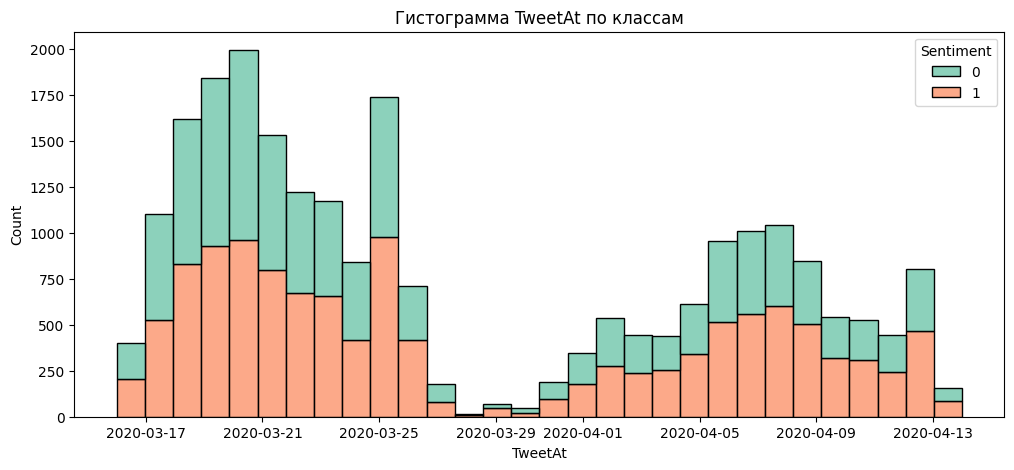

In [ ]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], dayfirst=True)

import seaborn as sns
plt.figure(figsize=(12, 5))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', bins=30, palette='Set2', multiple='stack')
plt.title("Гистограмма TweetAt по классам")
plt.show()

Можно заметить, что негативных твитов практически всегда на половину меньше, поэтому TweetAt сам по себе не даёт много полезной информации, потому что соотношение классов стабильное. Ни в какие дни не было резкого всплеска негативных твитов.



In [ ]:
train['Location'].nunique()

7949

Построим гистограмму топ-10 по популярности местоположений (исключая Unknown)

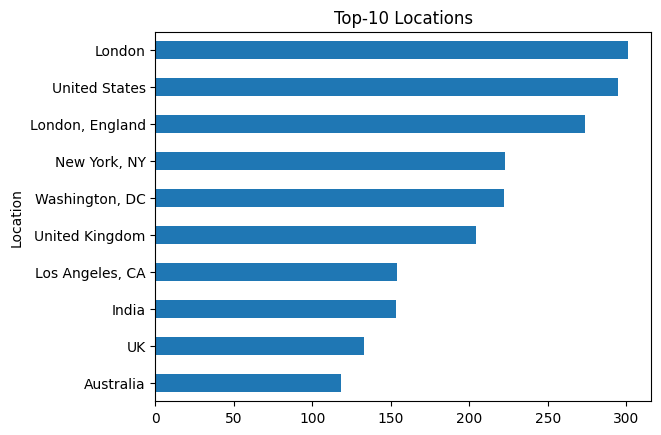

In [ ]:
location_counts = train['Location'].value_counts()
locations = location_counts[~location_counts.index.str.contains("Unknown")].head(10)

locations.plot(kind='barh', title="Top-10 Locations")
plt.gca().invert_yaxis()
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создадим новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK).

In [ ]:
def extract_wider(loc):
    if loc.lower() != "Unknown":
      parts = [p.strip() for p in loc.split(",")]
      return parts[-1]

train['WiderLocation'] = train['Location'].apply(extract_wider)
test['WiderLocation'] = test['Location'].apply(extract_wider)
train['WiderLocation'].nunique()

4631

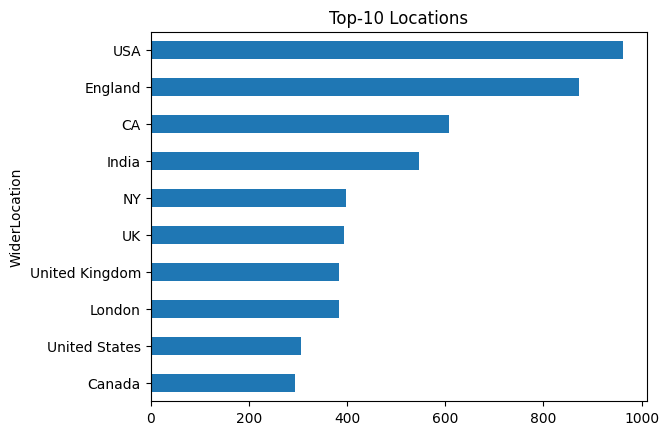

In [ ]:
location_counts = train['WiderLocation'].value_counts()
locations = location_counts[~location_counts.index.str.contains("Unknown")].head(10)

locations.plot(kind='barh', title="Top-10 Locations")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

common_locations = train['WiderLocation'].value_counts()
print(len(common_locations[common_locations > 1]))
common_locations = common_locations[common_locations > 1].index
train['WiderLocationFiltered'] = train['WiderLocation'].where(train['WiderLocation'].isin(common_locations), 'Other')

one = OneHotEncoder()
loc_encoded = one.fit_transform(train[['WiderLocationFiltered']])
X_final = hstack([X_train_scaled, loc_encoded])

test['WiderLocationFiltered'] = test['WiderLocation'].where(test['WiderLocation'].isin(common_locations), 'Other')


X_test = one.transform(test[['WiderLocationFiltered']])
X_test_final = hstack([X_test_scaled, X_test])

988


In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_final, y_train)
y_pred = model.predict(X_test_final)
y_pred_train = model.predict(X_final)
print("Final accuracy train and test:", accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred))

Final accuracy train and test: 0.9456642460486971 0.8445286027506478


Качество увеличилось только на train, поэтому признак оказался не очень полезным